In [1]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.physics.operators import Divergence_Operator, Laplacian_Operator, Gradient_2nd_Operator
from src.openfoam_utils.preload_mesh import preprocessed_OpenFOAM_mesh

dtype = torch.float32

In [2]:
def load_case_mesh(dir, bc_dict):
    vtk_file_reader = pv.POpenFOAMReader(dir)

    # Get Mesh
    mesh = preprocessed_OpenFOAM_mesh(dir, dim=2)

    # Get Ground Truth Data
    vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
    vtk_file_reader.cell_to_point_creation = False
    vtk_file_reader.enable_all_patch_arrays()
    vtk_mesh = vtk_file_reader.read()[0]
    U_gt = torch.tensor(vtk_mesh['U'], dtype = dtype).unsqueeze(0).unsqueeze(0)
    return mesh, vtk_mesh, U_gt

In [3]:
U_bc_dict = {
            'movingWall':{ "type":'fixedValue', "value":[1,0,0]},
            'fixedWalls':{ "type":'fixedValue', "value":[0,0,0]},  
            'frontAndBack':{ "type":'empty'}    
            }
p_bc_dict = {
    'movingWall':{ "type":'zeroGradient' },
    'fixedWalls':{ "type":'zeroGradient' },  
    'frontAndBack':{ "type":'empty'}    
}
bc_dict = {'U':U_bc_dict, 'p':p_bc_dict}

nu = 0.01

In [4]:
dir = r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_sparse_mesh_detail\case.foam'
mesh, vtk_mesh, U_gt =  load_case_mesh(dir, bc_dict)

Found 1024 values (header expected 1024)
Found 2112 values (header expected 1984)
Found 2112 values (header expected 1984)
Found 1984 values (header expected 1984)


In [5]:
mesh.bc_conditions = bc_dict

In [6]:
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=U_gt[...,:2])
lap_pred = Laplacian_Operator.caclulate(mesh, field=U_gt[...,:2])*nu

In [7]:
gradU2_pred = Gradient_2nd_Operator.caclulate(mesh, field=U_gt)

In [8]:
gradU_gt = torch.tensor(vtk_mesh['grad(U)'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt = torch.tensor(vtk_mesh['lapU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
divU_gt = torch.tensor(vtk_mesh['divU_phiAll'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)

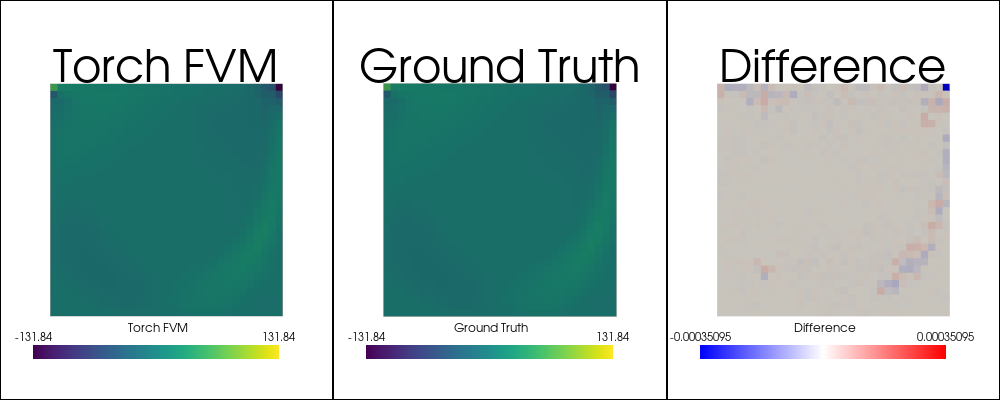

In [9]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
#for i, j in enumerate([0,1,3,4]):
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    )

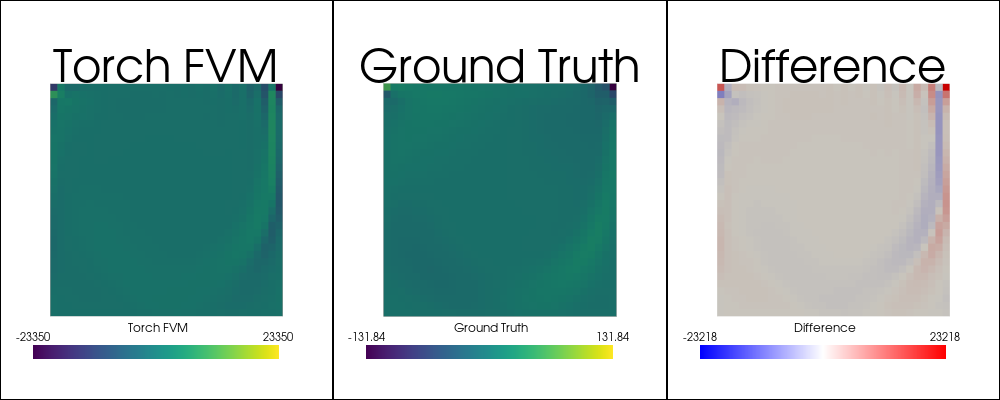

In [10]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
#for i, j in enumerate([0,1,3,4]):
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=gradU2_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    )

In [11]:
def calc_fdm2nd(u, S=256, L=0.1):
    U = torch.nn.functional.pad(u.reshape(1,S,S,3), (0,0,1,1,1,1))
    dx = dy = L/(S-1)

    # Fill out ghost nodes based on boundary conditions (hard coded)
    # Lid
    U[:,-1  , :  , 0] = -U[:,-2  , :  , 0] + 2.0
    U[:,-1  , :  , 1] = -U[:,-2  , :  , 1] 

    # Left Wall
    U[:, :  , 0  , :2] = -U[:, :  , 1  , :2]

    # Bottom Wall
    U[:, 0  , :  , :2] = -U[:, 1  , :  , :2]

    # Right Wall
    U[:, :  ,-1  , :2] = -U[:, :  ,-2  , :2]

    u_xx = (U[:, 1:-1, 2:  , 0] - 2*U[:, 1:-1, 1:-1, 0] + U[:, 1:-1,  :-2, 0]) / (dx**2)
    u_yy = (U[:, 2:  , 1:-1, 0] - 2*U[:, 1:-1, 1:-1, 0] + U[:,  :-2, 1:-1, 0]) / (dy**2)
    v_xx = (U[:, 1:-1, 2:  , 1] - 2*U[:, 1:-1, 1:-1, 1] + U[:, 1:-1,  :-2, 1]) / (dx**2)
    v_yy = (U[:, 2:  , 1:-1, 1] - 2*U[:, 1:-1, 1:-1, 1] + U[:,  :-2, 1:-1, 1]) / (dy**2)

    return u_xx, u_yy, v_xx, v_yy

In [12]:
def calc_fdm1st(u, S=256, L=0.1):
    U = torch.nn.functional.pad(u.reshape(1,S,S,3), (0,0,1,1,1,1))
    dx = dy = L/(S-1)

    # Fill out ghost nodes based on boundary conditions (hard coded)
    # Lid
    U[:,-1  , :  , 0] = -U[:,-2  , :  , 0] + 2.0
    U[:,-1  , :  , 1] = -U[:,-2  , :  , 1] 

    # Left Wall
    U[:, :  , 0  , :2] = -U[:, :  , 1  , :2]

    # Bottom Wall
    U[:, 0  , :  , :2] = -U[:, 1  , :  , :2]

    # Right Wall
    U[:, :  ,-1  , :2] = -U[:, :  ,-2  , :2]

    u_x  = (U[:, 1:-1, 2:  , 0] -   U[:, 1:-1,  :-2, 0]) / (2*dx)
    u_y  = (U[:, 2:  , 1:-1, 0] -   U[:,  :-2, 1:-1, 0]) / (2*dy)
    v_x  = (U[:, 1:-1, 2:  , 1] -   U[:, 1:-1,  :-2, 1]) / (2*dx)
    v_y  = (U[:, 2:  , 1:-1, 1] -   U[:,  :-2, 1:-1, 1]) / (2*dy)

    return u_x, u_y, v_x, v_y

In [13]:
def periodic_derivatives(x, dx=1.0, dy=1.0):
    """
    Compute first and second derivatives with 2nd-order central differences
    and periodic BCs.
    
    x: tensor of shape (B, N, N) or (B, N, N, C)
    dx, dy: grid spacing
    
    Returns:
        dx1, dy1 : first derivatives
        dx2, dy2 : second derivatives
    """
    if len(x.shape) == 4:
        x = torch.nn.functional.pad(x, (0,0,1,1,1,1))
    else:
        x = torch.nn.functional.pad(x, (1,1,1,1))

    # Lid
    x[:,-1  , :  , 0] = -x[:,-2  , :  , 0] + 2.0
    x[:,-1  , :  , 1] = -x[:,-2  , :  , 1] 
    # Left Wall
    x[:, :  , 0  , :2] = -x[:, :  , 1  , :2]
    # Bottom Wall
    x[:, 0  , :  , :2] = -x[:, 1  , :  , :2]
    # Right Wall
    x[:, :  ,-1  , :2] = -x[:, :  ,-2  , :2]

    # shift along x-direction (dim=1)
    x_ip = torch.roll(x, shifts=-1, dims=1)
    x_im = torch.roll(x, shifts=+1, dims=1)

    # shift along y-direction (dim=2)
    y_ip = torch.roll(x, shifts=-1, dims=2)
    y_im = torch.roll(x, shifts=+1, dims=2)

    # First derivatives: (f[i+1] - f[i-1]) / (2*dx)
    dx1 = (x_ip - x_im) / (2.0 * dx)
    dy1 = (y_ip - y_im) / (2.0 * dy)

    # Second derivatives: (f[i+1] - 2f[i] + f[i-1]) / dx^2
    dx2 = (x_ip - 2.0 * x + x_im) / (dx * dx)
    dy2 = (y_ip - 2.0 * x + y_im) / (dy * dy)

    grad_dict = {'dwdx':dx1[:,1:-1,1:-1],
                 'dwdy':dy1[:,1:-1,1:-1],
                 'dwdxx':dx2[:,1:-1,1:-1],
                 'dwdyy':dy2[:,1:-1,1:-1]
                 }
    
    return grad_dict

In [14]:
grad_dict = periodic_derivatives(U_gt.reshape(1,32,32,3), dx=0.1/(32-1), dy=0.1/(32-1))

In [16]:
selection_pred = gradU_pred.reshape(32,32,4)
selection_ftm = calc_fdm1st(U_gt, S=32, L=0.1)
selection_ftm = [i[0,...] for i in selection_ftm]

In [19]:
gradU2_pred.shape

torch.Size([1, 1, 1024, 12])

In [25]:
selection_pred = gradU2_pred.reshape(32,32,12)
selection_ftm = calc_fdm2nd(U_gt, S=32, L=0.1)
selection_ftm = [i[0,...] for i in selection_ftm]

In [21]:
grad_dict['dwdx'][...,0].shape

torch.Size([1, 32, 32])

In [26]:
vtk_mesh

UnstructuredGrid (0x1cd3cad0dc0)
  N Cells:    1024
  N Points:   2178
  X Bounds:   0.000e+00, 1.000e-01
  Y Bounds:   0.000e+00, 1.000e-01
  Z Bounds:   0.000e+00, 1.000e-02
  N Arrays:   10

In [29]:
import plotly.graph_objects as go
import plotly.subplots as subplots
rows=1
cols=3

row1_fig=selection_pred[...,0]
row2_fig=selection_ftm[0]
row3_fig=(row1_fig-row2_fig)/row2_fig

fig = subplots.make_subplots(rows,cols, subplot_titles=('FVM','FDM','Dif'))
fig.add_trace(go.Heatmap(z=row1_fig, showscale=False),1,1)
fig.add_trace(go.Heatmap(z=row2_fig, showscale=False),1,2)
fig.add_trace(go.Heatmap(z=row3_fig, showscale=True, colorscale='Viridis'),1,3)
for i in range(1, rows*cols + 1):
    fig.update_xaxes(scaleanchor=f"y{i}", scaleratio=1, row=(i-1)//cols + 1, col=(i-1)%cols + 1)
    fig.update_yaxes(constrain='domain', row=(i-1)//cols + 1, col=(i-1)%cols + 1)
fig.show()

In [ ]:
from src.gauss_green import gaus_green_vfm_mesh
vtk_file_reader = pv.POpenFOAMReader(dir)
mesh_old = gaus_green_vfm_mesh(vtk_file_reader, dtype = dtype, bc_dict=bc_dict)

Trying to fetch cell centers and volume from Openfoam Data mesh...
An error was encountered when trying to load Cell and Volume files
 'C' 
Manually calculating cell centers and volume for mesh...
Successfully Calculated True Geometric Cell Centroids
Calculating face centers and areas for 4160 faces
{'max_non_orthogonality': 0.0, 'avg_non_orthogonality': 0.0, 'max_skewness': 2.3841880647523794e-06, 'avg_skewness': 2.975726260956435e-07}
 Found Patch "movingWall" with 32 Faces
 Found Patch "fixedWalls" with 96 Faces
Boundary faces indexed: 128/2176 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.5000,               max w:0.5000,               mean w:0.5000


In [ ]:
gradU2_pred2 = Gradient_2nd_Operator.caclulate(mesh_old, field=U_gt)

In [ ]:
mesh_old.delta.shape

torch.Size([4160, 3])

In [ ]:
from src.openfoam_utils.polymesh_parsing import *
parse_openfoam_face_values(r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_sparse_mesh_detail\constant\polyMesh\points')

ValueError: No internalField nonuniform List<scalar/vector> found

In [ ]:
import re
with open(r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_sparse_mesh_detail\constant\polyMesh\points', 'r') as f:
    content = f.read()
    
points_start = content.find('(\n') + 2
points_text = content[points_start : content.rfind(')')]
    
points = []
for line in points_text.strip().split('\n'):
    if line.strip().startswith('('):
        x, y, z = map(float, re.findall(r'[-+]?\d*\.?\d+', line))
        points.append([x, y, z])

In [ ]:
n_points

12

In [ ]:
len(points)

2178